In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Smart progress meter
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
# Configure Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# MNIST Train-Test Datasets
train_ds = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor())

In [23]:
# Data loader
train_dl = torch.utils.data.DataLoader(dataset = train_ds, batch_size=100, shuffle=True)
test_dl = torch.utils.data.DataLoader(dataset = test_ds, batch_size=100, shuffle=False)

In [32]:
# Show Some Examples
examples = iter(test_dl)
examples_images, example_targets = next(examples)

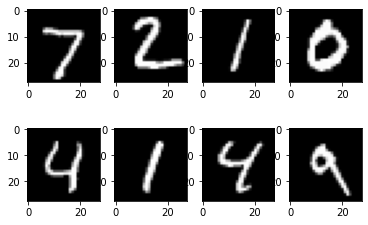

In [35]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(examples_images[i][0], cmap='gray')
plt.show()

In [37]:
# Input size=784, since image size 28 x 28 = 784
# Fully connected NN with two hidden layers
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(28 * 28, 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 10) # 10 Classes
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        # No activation needed at the end
        return x

model = Net().to(device)

In [39]:
# Criterion (Loss) and Optimizer
criterion =nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [57]:
# Training
num_epochs = 3 # Number of epochs
epochs = tqdm(range(num_epochs))

for epoch in epochs:
    train_loss = []
    model.train()
    for batch in (train_dl):
        optim.zero_grad()
        images = batch[0].reshape(-1, 28 * 28).to(device)
        label = batch[1].to(device)
        # Forward-pass
        output = model(images)
        loss = torch.nn.CrossEntropyLoss()(output.squeeze(-1), label)
        # Backward-pass and optimize
        loss.backward()
        optim.step()
        train_loss.append(loss.item())
    
    
    loss_now = np.mean(train_loss)
    epochs.set_postfix({'loss':loss_now})
    
# Test
# Initialize the prediction and label lists(tensors)
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

with torch.no_grad():
    for ims, labels in test_dl:
        ims = ims.reshape(-1, 28 * 28).to(device)
        labels = labels.to(device)
        outputs = model(ims)
        _, predicted = torch.max(outputs.data, 1)
        # Append batch prediction results
        predlist = torch.cat([predlist, predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])
        
# Confusion matrix
conf_mat = confusion_matrix(np.asarray(lbllist), np.asarray(predlist))
print(conf_mat)
# Per-class accuracy
class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)
print(class_accuracy)
# Report 
print(classification_report(np.asarray(lbllist),np.asarray(predlist),digits=3))

  0%|          | 0/3 [00:00<?, ?it/s]

[[ 970    0    0    0    3    0    2    2    2    1]
 [   0 1119    2    3    0    1    4    2    4    0]
 [   6    1  998    5    3    0    3    8    7    1]
 [   0    0    1  988    0    6    0    4    5    6]
 [   0    0    3    0  958    0    4    2    1   14]
 [   2    0    0    5    1  875    4    0    4    1]
 [   5    2    1    1    4    2  942    0    1    0]
 [   1    1    6    1    0    0    0 1015    1    3]
 [   8    1    1    4    4    7    3    2  938    6]
 [   1    2    0    3    8    4    1    3    2  985]]
[98.97959184 98.59030837 96.70542636 97.82178218 97.55600815 98.0941704
 98.32985386 98.73540856 96.30390144 97.62140733]
              precision    recall  f1-score   support

           0      0.977     0.990     0.983       980
           1      0.994     0.986     0.990      1135
           2      0.986     0.967     0.977      1032
           3      0.978     0.978     0.978      1010
           4      0.977     0.976     0.976       982
           5      0.97